In [11]:
import netket as nk
import matplotlib

import sys
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/models')
from vmc_2spins_sampler import *
from Afm_Model_functions import *
import ViT_2d_Vers5 as vit

from netket.utils import HashableArray
import jax.numpy as jnp
import jax

from flax.linen.initializers import xavier_uniform, variance_scaling
import matplotlib.pyplot as plt

In [4]:
L=4
# hi2d = nk.hilbert.Spin(s=0.5, N=L**2)
pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5
}

# Ha16 = H_afm(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'])
Ha16, hi2d_even = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True, parity=0.)
TriGraph = nk.graph.Triangular(extent=[L,L], pbc=True)
XX = Exchange_OP(hi2d_even, TriGraph)

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d_even, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d_even.size)
# sa_2flip = nk.sampler.MetropolisSampler(hilbert=hi2d, rule=TwoLocalRule(), n_chains=32, sweep_size=3*hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d_even, graph=TriGraph, n_chains=32, sweep_size=3*hi2d_even.size)


rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
rules3070 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.3, 0.7])
rules7030 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.7, 0.3])

sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d_even, rules5050, n_chains=32, sweep_size=3*hi2d_even.size)
sa_HaEx3070 = nk.sampler.MetropolisSampler(hi2d_even, rules3070, n_chains=32, sweep_size=3*hi2d_even.size)
sa_HaEx7030 = nk.sampler.MetropolisSampler(hi2d_even, rules7030, n_chains=32, sweep_size=3*hi2d_even.size)

sa_exc = nk.sampler.ExactSampler(hilbert=hi2d_even)


In [8]:
pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 1,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.arange(0, L**2).reshape((-1,2))),
}

In [10]:
var_init = variance_scaling(scale=0.01, mode= 'fan_in', distribution='truncated_normal')

mvit = vit.ViT_2d(patch_arr=pVit['patch_arr'], embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                kern_init_rbm=var_init, kern_init_vit=xavier_uniform(), use_rbm_hidden_bias=True, use_rbm_visible_bias=True)



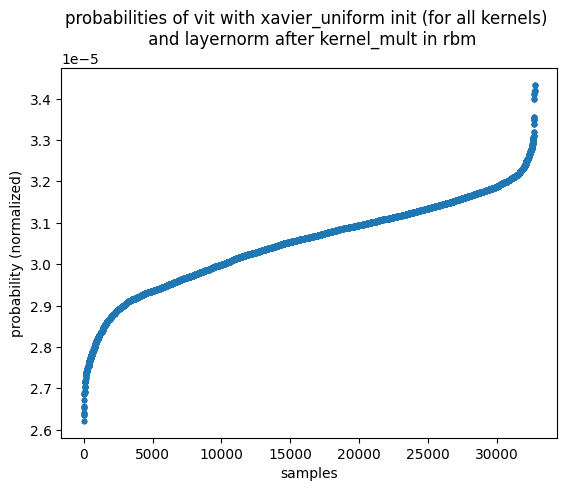

In [14]:
vs = nk.vqs.MCState(sampler=sa_exc, model=mvit, n_samples=2**12)
vs = nk.vqs.FullSumState(hilbert=hi2d_even, model=mvit)

vit_probs = jnp.exp(2 * jnp.real(vs.log_value(hi2d_even.all_states())))
vit_probs /= jnp.sum(vit_probs,axis=-1)

plt.title('probabilities of vit with xavier_uniform init (for all kernels) \n and layernorm after kernel_mult in rbm')
plt.ylabel('probability (normalized)')
plt.xlabel('samples')
plt.plot(jnp.sort(vit_probs), '.')
plt.show()

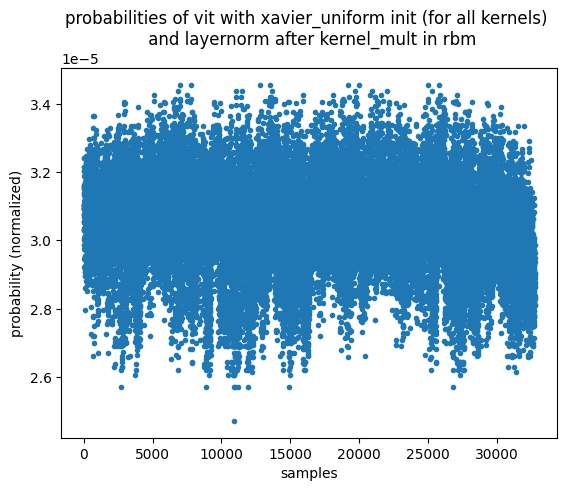

In [19]:
vs = nk.vqs.MCState(sampler=sa_HaEx5050, model=mvit, n_samples=2**12)
vit_probs = jnp.exp(2 * jnp.real(vs.log_value(hi2d_even.all_states())))
vit_probs /= jnp.sum(vit_probs,axis=-1)

plt.title('probabilities of vit with xavier_uniform init (for all kernels) \n and layernorm after kernel_mult in rbm')
plt.ylabel('probability (normalized)')
plt.xlabel('samples')
# plt.plot(jnp.sort(vit_probs), '.')
plt.plot((vit_probs), '.')

plt.show()